In [1]:
# Imports the LSTM model and library
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import InputLayer, LSTM, Dense
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

In [2]:
df = pd.read_excel("/content/ReidVille_data_ML_updated.xlsx")


In [3]:
df.head(5)

,Date,Temp_mean,PPT,Streamflow
0,1982-01-01,-5.35,0.10,16.1
1,1982-01-02,-5.94,3.42,15.4
2,1982-01-03,-1.92,1.27,14.4
3,1982-01-04,-4.32,0.09,13.7
4,1982-01-05,-1.20,14.19,13.0


In [4]:
df.columns = df.columns.str.strip()
df.index = pd.to_datetime(df['Date'], format='%Y.%m.%d')
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14975 entries, 1982-01-01 to 2022-12-31
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        14975 non-null  datetime64[ns]
 1   Temp_mean   14975 non-null  float64       
 2   PPT         14975 non-null  float64       
 3   Streamflow  14975 non-null  float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 585.0 KB


In [5]:
# Strip spaces from all column names
df.columns = df.columns.str.strip()

# Now you can use 'Date' without the space
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y', errors='coerce')
df.set_index('Date', inplace=True)
df.head()


,Temp_mean,PPT,Streamflow
Date,,,
1982-01-01,-5.35,0.10,16.1
1982-01-02,-5.94,3.42,15.4
1982-01-03,-1.92,1.27,14.4
1982-01-04,-4.32,0.09,13.7
1982-01-05,-1.20,14.19,13.0


In [8]:
print(df.columns)


Index(['Temp_mean', 'PPT', 'Streamflow'], dtype='object')


<Axes: xlabel='Date'>

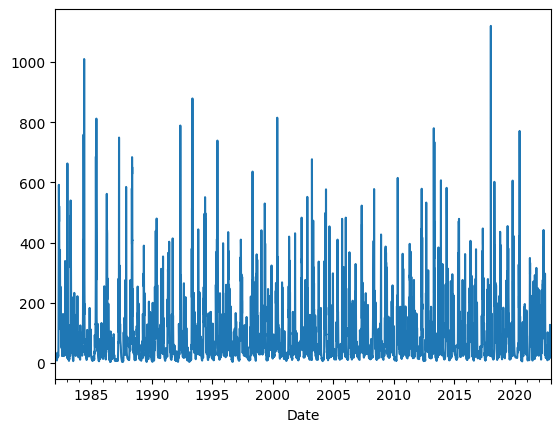

In [7]:
flow = df['Streamflow']
flow.plot()


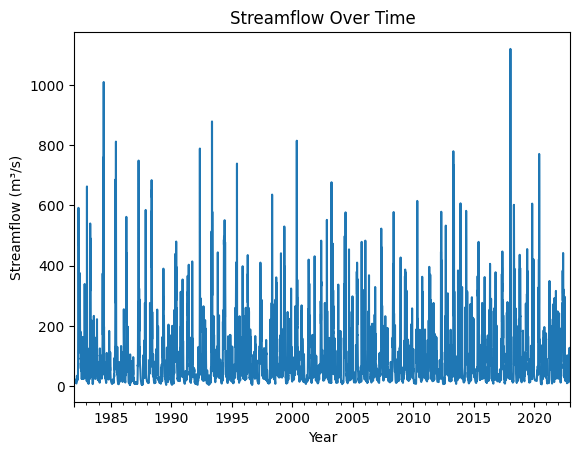

In [11]:
import matplotlib.pyplot as plt

flow = df['Streamflow']
flow.plot(xlabel='Year', ylabel='Streamflow (m³/s)', title='Streamflow Over Time')
plt.show()


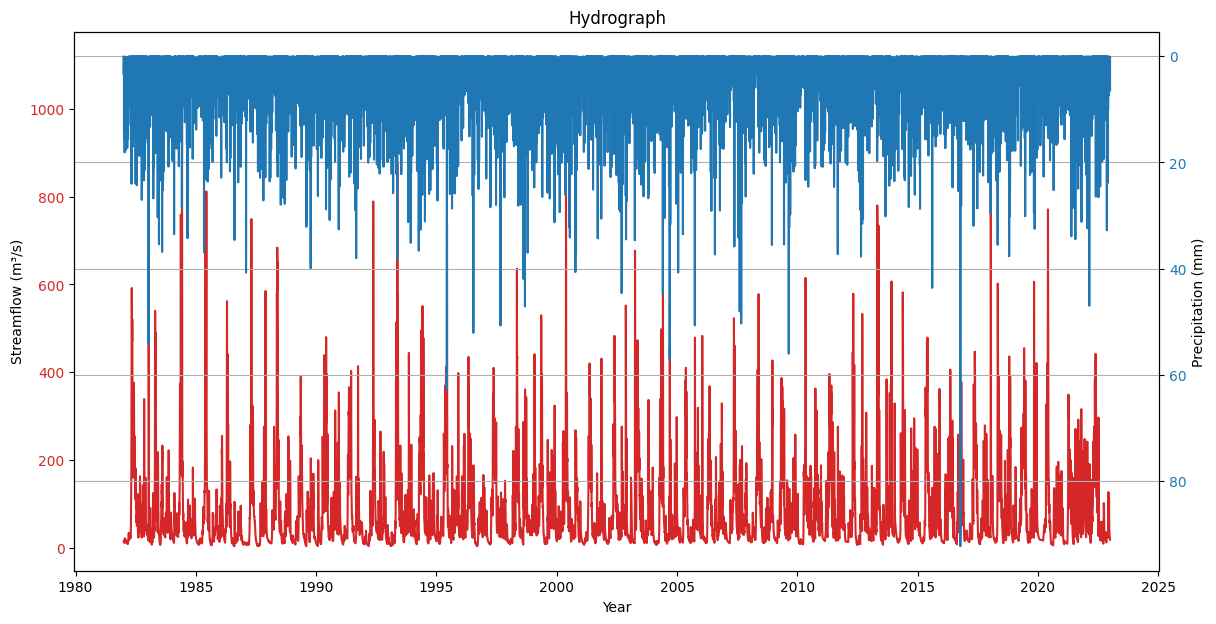

In [17]:
# Create the plot with two y-axes
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot Precipitation on the first y-axis
color = 'tab:red'
ax1.set_xlabel('Year')
ax1.set_ylabel('Streamflow (m³/s)')
ax1.plot(df.index, df['Streamflow'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis for Streamflow
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_xlabel('Year')
ax2.set_ylabel('Precipitation (mm)')
ax2.plot(df.index, df['PPT'])
ax2.tick_params(axis='y', labelcolor=color)

# Invert the y-axis of ax2
ax2.invert_yaxis()

# Adding a title and a grid
#plt.title('Precipitation and Streamflow Over Time')
plt.title('Hydrograph')
plt.grid(True)

# Show the plot
plt.show()


In [10]:
import matplotlib.pyplot as plt

# Assuming 'df' is already loaded and contains 'PPT' and 'Streamflow' columns
data_to_plot = [df['PPT'], df['Streamflow', df['Temp_mean']]]

# Create a figure instance and an axes instance
fig, ax = plt.subplots(figsize=(8, 6))

# Create the box plot
bp = ax.boxplot(data_to_plot, patch_artist=True, notch=True, vert=True)

# Customizing colors for each box
colors = ['blue', 'red']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

# Adding labels for each dataset
ax.set_xticklabels(['Precipitation (mm)', 'Streamflow (m³/s)'])

# Adding a title and a grid
plt.title('Box Plot of Precipitation and Streamflow')
plt.grid(True)

# Show the plot
plt.show()


InvalidIndexError: ('Streamflow', Date
1982-01-01   -5.35
1982-01-02   -5.94
1982-01-03   -1.92
1982-01-04   -4.32
1982-01-05   -1.20
              ... 
2022-12-27   -5.27
2022-12-28   -7.95
2022-12-29   -8.71
2022-12-30   -7.39
2022-12-31    0.11
Name: Temp_mean, Length: 14975, dtype: float64)

In [58]:
# [[[1], [2], [3], [4], [5]]] [6]
# [[[2], [3], [4], [5], [6]]] [7]
# [[[3], [4], [5], [6], [7]]] [8]

def df_to_X_y(df, window_size=5):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)

In [59]:
WINDOW_SIZE = 5
X1, y1 = df_to_X_y(flow, WINDOW_SIZE)
X1.shape, y1.shape

((14970, 5, 1), (14970,))

In [60]:
X_train1, y_train1 = X1[:10000], y1[:10000]
X_val1, y_val1 = X1[10000:12000], y1[10000:12000]
X_test1, y_test1 = X1[12000:], y1[12000:]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((10000, 5, 1), (10000,), (2000, 5, 1), (2000,), (2970, 5, 1), (2970,))

In [61]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam



In [62]:
model1 = Sequential()
model1.add(InputLayer((5, 1)))
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 64)                16896     
                                                                 
 dense_8 (Dense)             (None, 8)                 520       
                                                                 
 dense_9 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17425 (68.07 KB)
Trainable params: 17425 (68.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [63]:
from tensorflow.keras.utils import plot_model


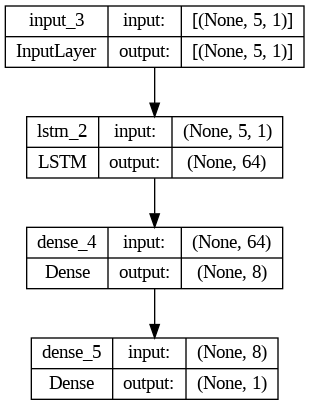

In [34]:
from keras.models import Sequential
from keras.layers import Dense
#from keras.utils.vis_utils import plot_model
plot_model(model1, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [66]:
cp1 = ModelCheckpoint('model1/', save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])


In [67]:
model1.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=150, callbacks=[cp1])

Epoch 1/150
313/313 [==============================] - 9s 22ms/step - loss: 14809.1230 - root_mean_squared_error: 121.6927 - val_loss: 14324.6396 - val_root_mean_squared_error: 119.6856
Epoch 2/150
313/313 [==============================] - 5s 17ms/step - loss: 13669.3857 - root_mean_squared_error: 116.9161 - val_loss: 12499.4453 - val_root_mean_squared_error: 111.8009
Epoch 3/150
313/313 [==============================] - 6s 20ms/step - loss: 12117.2344 - root_mean_squared_error: 110.0783 - val_loss: 11124.6035 - val_root_mean_squared_error: 105.4732
Epoch 4/150
313/313 [==============================] - 5s 18ms/step - loss: 10901.3711 - root_mean_squared_error: 104.4096 - val_loss: 10074.0732 - val_root_mean_squared_error: 100.3697
Epoch 5/150
313/313 [==============================] - 6s 18ms/step - loss: 10032.4531 - root_mean_squared_error: 100.1621 - val_loss: 9244.8750 - val_root_mean_squared_error: 96.1503
Epoch 6/150
313/313 [==============================] - 6s 18ms/step - lo

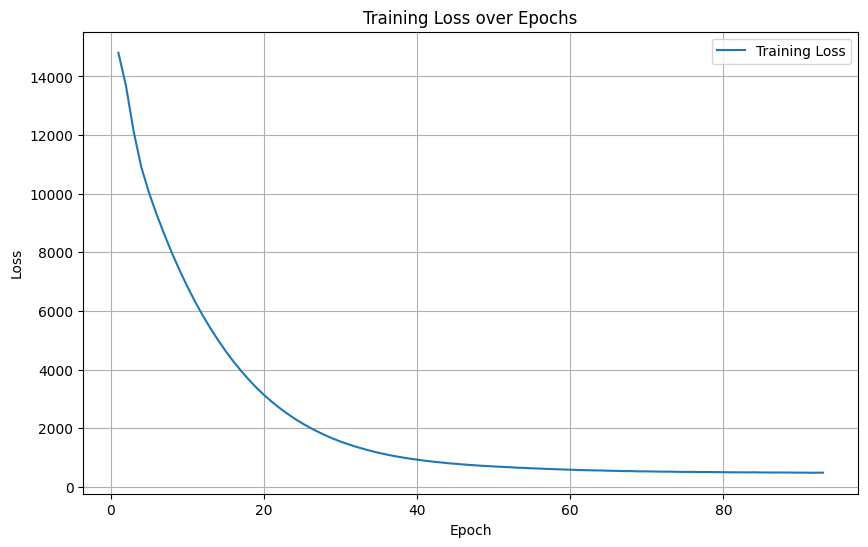

In [74]:

import matplotlib.pyplot as plt

# Define the data
epochs = list(range(1, 94))  # Assuming you have 90 epochs based on your data
train_loss = [14809.1230, 13669.3857, 12117.2344, 10901.3711, 10032.4531, 9290.7959, 8614.1797, 7972.9302, 7384.0625, 6836.3560, 6325.9736, 5854.5698, 5418.8979, 5013.8052, 4635.3018, 4285.8970, 3964.4573, 3667.2375, 3392.6216, 3140.8425, 2911.4790, 2701.4319, 2509.0122, 2331.5466, 2169.8352, 2021.9078, 1888.0822, 1763.1472, 1649.1757, 1547.1023, 1456.2471, 1372.3398, 1296.4150, 1225.9890, 1162.0074, 1106.0283, 1054.2316, 1008.3558, 966.6556, 930.5950, 895.0610, 864.4701, 837.3801, 810.1680, 788.2938, 766.6711, 747.4758, 728.4042, 714.5332, 698.5751, 685.0072, 672.2253, 657.2141, 647.5391, 634.5522, 624.6235, 613.2646, 605.5199, 595.2843, 586.8016, 578.7650, 570.7684, 564.7103, 561.0589, 552.5693, 546.8063, 540.4703, 539.1733, 529.3929, 529.6456, 525.6002, 520.4513, 520.3002, 515.8617, 511.7372, 512.8115, 507.3411, 507.7587, 505.4864, 502.2672, 498.6806, 498.4871, 495.0844, 498.4871, 493.3513, 491.2383, 491.9750, 491.9750, 489.6010, 486.3729, 486.0435, 484.0583, 486.0435]
#val_loss = [14324.6396, 12499.4453, 11124.6035, 10074.0732, 9244.8750, 8510.2402, 7821.3003, 7200.2837, 6631.2856, 6110.0957, 5633.4990, 5194.0444, 4796.9556, 4437.3701, 4104.1401, 3807.6697, 3535.7588, 3286.4478, 3060.2185, 2852.9414, 2661.1663, 2491.4956, 2329.7476, 2190.3289, 2058.1790, 1932.3407, 1819.8756, 1723.5416, 1622.3254, 1538.7699, 1468.4648, 1400.9595, 1330.0583, 1275.1995, 1233.8666, 1177.4578, 1137.8956, 1106.7709, 1067.5865, 1031.5103, 1009.0507, 980.1799, 958.7023, 931.2319, 922.4396, 899.9105, 877.0741, 879.3292, 851.1660, 833.2046, 829.7667, 809.7219, 810.7612, 791.9863, 783.6566, 763.2266, 756.6174, 754.5693, 744.2006, 733.2920, 732.0405, 720.1646, 717.5974, 716.2820, 705.7469, 704.5444, 703.0010, 695.6656, 693.9178, 688.4888, 688.8911, 682.9544, 679.1305, 673.5717, 674.6786, 667.2383, 664.1047, 664.6534, 659.7711, 658.7800, 656.3624, 652.4487, 649.8392, 647.0981, 649.8392, 643.4000, 644.9735, 641.0719, 641.0719, 639.0800, 635.7545, 635.0504, 633.2441, 634.0977]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, label='Training Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()



In [ ]:
# history = model1.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=120, callbacks=[cp1])

In [8]:
from tensorflow.keras.models import load_model
model1 = load_model('model1/')

OSError: No file or directory found at model1/

In [4]:
import math  # Import the math module to use its sqrt function

trainScore = model1.evaluate(X_train1, y_train1, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))

testScore = model1.evaluate(X_test1, y_test1, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))



NameError: name 'model1' is not defined

In [5]:
# Plot the model loss over epochs
plt.plot(range(len(model1.history.history['loss'])), model1.history.history['loss'], label='Training Loss')
#plt.plot(range(len(model1.history.history['val_loss'])), model1.history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()




NameError: name 'plt' is not defined

In [6]:
train_predictions = model1.predict(X_train1).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train1})
train_results

NameError: name 'model1' is not defined

In [7]:
import matplotlib.pyplot as plt
plt.plot(train_results['Train Predictions'][1:365])
plt.plot(train_results['Actuals'][1:365])

NameError: name 'train_results' is not defined

In [77]:
# Extract the dates that correspond to your training predictions
train_dates = df.index[WINDOW_SIZE:WINDOW_SIZE + len(train_predictions)]

# Create a DataFrame with predictions, actuals, and dates
train_results = pd.DataFrame({
    'Date': train_dates,
    'Train Predictions': train_predictions,
    'Actuals': y_train1
}).set_index('Date')

# Show the first few rows to verify
print(train_results.head(100))

            Train Predictions  Actuals
Date                                  
1982-01-06          12.652940     13.6
1982-01-07          15.844018     14.0
1982-01-08          14.409545     13.5
1982-01-09          12.498050     12.9
1982-01-10          12.614736     12.4
...                       ...      ...
1982-04-11          26.506193     25.4
1982-04-12          25.669369     24.4
1982-04-13          24.085691     23.4
1982-04-14          22.977936     22.8
1982-04-15          23.023109     22.1

[100 rows x 2 columns]


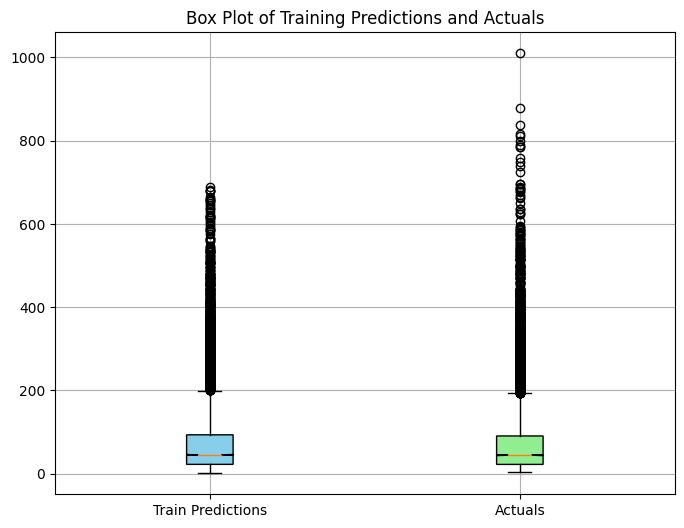

In [78]:
import matplotlib.pyplot as plt

# Assuming 'train_results' is already created and contains 'Train Predictions' and 'Actuals' columns
data_to_plot = [train_results['Train Predictions'], train_results['Actuals']]

# Create a figure instance and an axes instance
fig, ax = plt.subplots(figsize=(8, 6))

# Create the box plot
bp = ax.boxplot(data_to_plot, patch_artist=True, notch=True, vert=True, labels=['Train Predictions', 'Actuals'])

# Customizing colors for each box
colors = ['skyblue', 'lightgreen']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

# Adding a title and a grid
plt.title('Box Plot of Training Predictions and Actuals')
plt.grid(True)

# Show the plot
plt.show()


NaN in Train Predictions: 0
NaN in Actuals: 0

Five-number summary for Train Predictions:
count    10000.000000
mean        77.253639
std         90.167877
min          1.169449
25%         22.590669
50%         45.285124
75%         93.529936
max        688.632019
Name: Train Predictions, dtype: float64

Five-number summary for Actuals:
count    10000.000000
mean        77.919476
std         94.960548
min          3.700000
25%         22.500000
50%         44.600000
75%         90.825000
max       1010.000000
Name: Actuals, dtype: float64


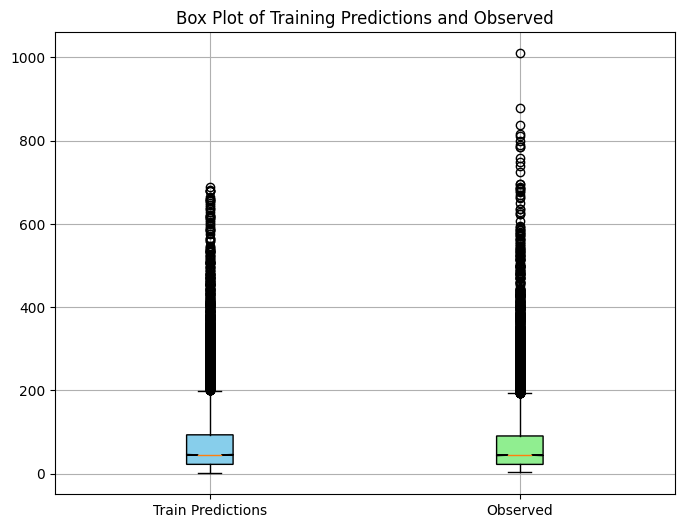

In [81]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'train_results' is your DataFrame
# Check for NaN values in your data
print("NaN in Train Predictions:", train_results['Train Predictions'].isna().sum())
print("NaN in Actuals:", train_results['Actuals'].isna().sum())

# Calculate and print the five-number summary for both predictions and actuals
print("\nFive-number summary for Train Predictions:")
print(train_results['Train Predictions'].describe())

print("\nFive-number summary for Actuals:")
print(train_results['Actuals'].describe())

# Create the box plot ensuring outliers are shown
fig, ax = plt.subplots(figsize=(8, 6))
data_to_plot = [train_results['Train Predictions'].dropna(), train_results['Actuals'].dropna()]
bp = ax.boxplot(data_to_plot, patch_artist=True, notch=True, vert=True, showfliers=True, labels=['Train Predictions', 'Observed'])

# Customizing colors for each box
colors = ['skyblue', 'lightgreen']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

# Adding a title and a grid
plt.title('Box Plot of Training Predictions and Observed')
plt.grid(True)

# Show the plot
plt.show()


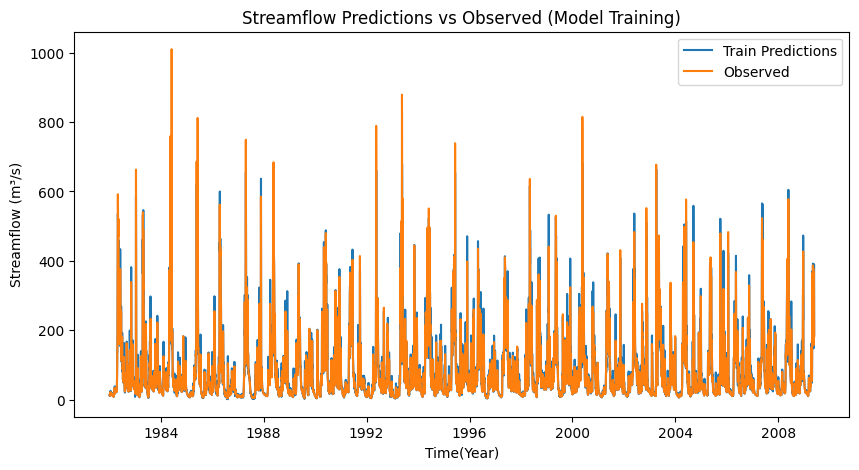

In [87]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_results['Train Predictions'], label='Train Predictions')
plt.plot(train_results['Actuals'], label='Observed')
plt.title('Streamflow Predictions vs Observed (Model Training)')
plt.xlabel('Time(Year)')
plt.ylabel('Streamflow (m³/s)')
plt.legend()
plt.show()


In [112]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Define evaluation functions
def calculate_nse(actuals, predictions):
    """
    Nash-Sutcliffe Efficiency
    """
    return 1 - (np.sum((predictions - actuals) ** 2) / np.sum((actuals - np.mean(actuals)) ** 2))

def calculate_rmse(actuals, predictions):
    """
    Root Mean Squared Error
    """
    return np.sqrt(mean_squared_error(actuals, predictions))

def calculate_mae(actuals, predictions):
    """
    Mean Absolute Error
    """
    return mean_absolute_error(actuals, predictions)

def calculate_r2(actuals, predictions):
    """
    Coefficient of Determination (R^2)
    """
    return r2_score(actuals, predictions)

# Assuming train_results DataFrame with columns 'Train Predictions' and 'Actuals'
actuals_train = train_results['Actuals']
predictions_train = train_results['Train Predictions']

# Calculate metrics
nse_train = calculate_nse(actuals_train, predictions_train)
rmse_train = calculate_rmse(actuals_train, predictions_train)
mae_train = calculate_mae(actuals_train, predictions_train)
r2_train = calculate_r2(actuals_train, predictions_train)

# Print the results with two decimal places
print("Evaluation Metrics for Model Training Period:")
print("Nash-Sutcliffe Efficiency (NSE): {:.2f}".format(nse_train))
print("Root Mean Squared Error (RMSE): {:.2f}".format(rmse_train))
print("Mean Absolute Error (MAE): {:.2f}".format(mae_train))
print("Coefficient of Determination (R^2): {:.2f}".format(r2_train))


Evaluation Metrics for Model Training Period:
Nash-Sutcliffe Efficiency (NSE): 0.95
Root Mean Squared Error (RMSE): 20.91
Mean Absolute Error (MAE): 8.60
Coefficient of Determination (R^2): 0.95


In [92]:
val_predictions = model1.predict(X_val1).flatten()
val_results = pd.DataFrame(data={'Val Predictions':val_predictions, 'Actuals':y_val1})
val_results

63/63 [==============================] - 0s 3ms/step


,Val Predictions,Actuals
0,151.039078,160.0
1,159.218094,155.0
2,154.646317,198.0
3,248.103989,234.0
4,223.090805,189.0
...,...,...
1995,301.346741,295.0
1996,277.279205,250.0
1997,182.905991,171.0
1998,121.596069,122.0


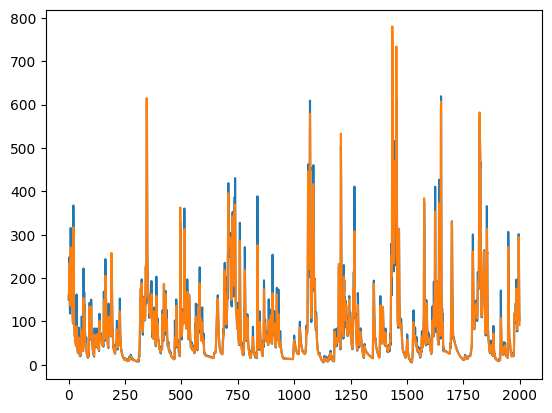

In [93]:
plt.plot(val_results)

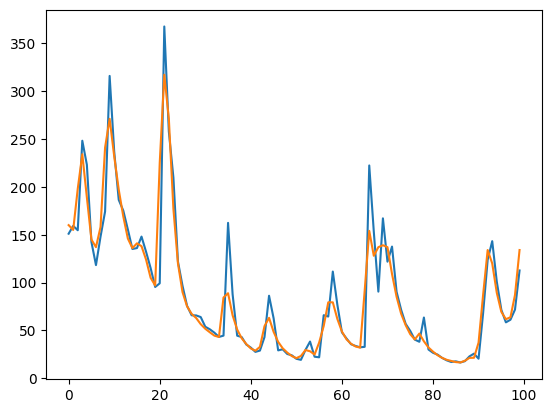

In [89]:
plt.plot(val_results['Val Predictions'][:100])
plt.plot(val_results['Actuals'][:100])

In [90]:
test_predictions = model1.predict(X_test1).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test1})
test_results

93/93 [==============================] - 0s 3ms/step


,Test Predictions,Actuals
0,78.074158,76.2
1,67.447960,70.3
2,71.195923,63.9
3,61.962746,57.7
4,56.064327,58.1
...,...,...
2965,22.971743,22.4
2966,21.116512,21.1
2967,20.097803,20.0
2968,19.445908,19.0


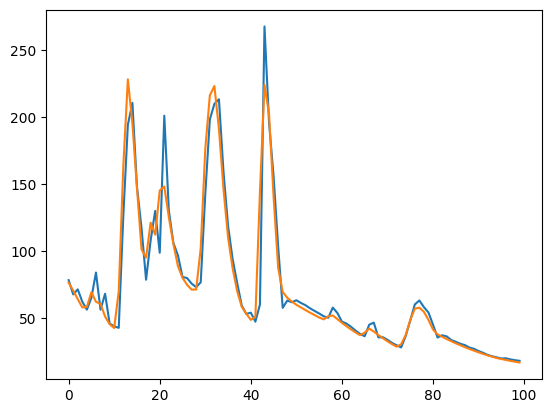

In [91]:
plt.plot(test_results['Test Predictions'][:100])
plt.plot(test_results['Actuals'][:100])

In [2]:
# Calculate the start index for validation and test sets
val_start_idx = WINDOW_SIZE + len(X_train1)
test_start_idx = val_start_idx + len(X_val1)

# Extract the corresponding date indices for validation and test datasets
val_dates = df.index[val_start_idx:val_start_idx + len(val_predictions)]
test_dates = df.index[test_start_idx:test_start_idx + len(test_predictions)]

# Create DataFrames that include the dates
val_results = pd.DataFrame({
    'Date': val_dates,
    'Val Predictions': val_predictions,
    'Actuals': y_val1
}).set_index('Date')

test_results = pd.DataFrame({
    'Date': test_dates,
    'Test Predictions': test_predictions,
    'Actuals': y_test1
}).set_index('Date')

NameError: name 'WINDOW_SIZE' is not defined

In [3]:

# Calculate the start index for validation and test sets
val_start_idx = WINDOW_SIZE + len(X_train1)
test_start_idx = val_start_idx + len(X_val1)

# Extract the corresponding date indices for validation and test datasets
val_dates = df.index[val_start_idx:val_start_idx + len(X_val1)]
test_dates = df.index[test_start_idx:test_start_idx + len(X_test1)]

# Create DataFrames that include the dates
val_results = pd.DataFrame({
    'Date': val_dates,
    'Val Predictions': val_predictions,
    'Actuals': y_val1
}).set_index('Date')

test_results = pd.DataFrame({
    'Date': test_dates,
    'Test Predictions': test_predictions,
    'Actuals': y_test1
}).set_index('Date')

# Combine validation and test results into one DataFrame for plotting
evaluation_results = pd.concat([val_results, test_results])

# Plot for test results
plt.figure(figsize=(12, 6))
plt.plot(evaluation_results.index[:100], evaluation_results['Val Predictions'][:100], label='Validation Predictions')
plt.plot(evaluation_results.index[:100], evaluation_results['Test Predictions'][:100], label='Test Predictions', alpha=0.7)
plt.plot(evaluation_results.index[:100], evaluation_results['Actuals'][:100], label='Actuals', alpha=0.5)
plt.title('Test and Validation Predictions vs Actuals')
plt.xlabel('Date')
plt.ylabel('Streamflow')
plt.legend()
plt.show()


NameError: name 'X_train1' is not defined

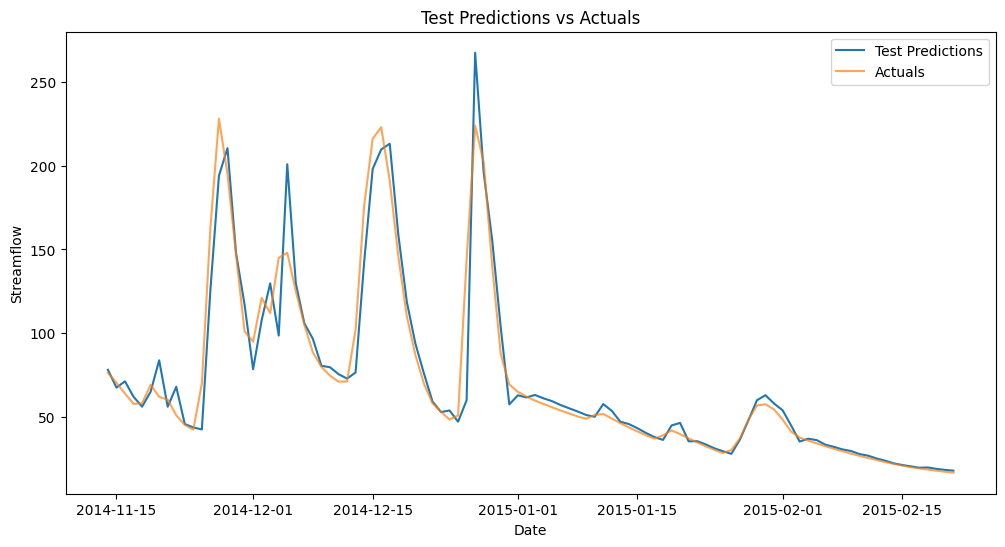

In [95]:
# Plot for test results
plt.figure(figsize=(12, 6))
plt.plot(test_results['Test Predictions'][:100], label='Test Predictions')
plt.plot(test_results['Actuals'][:100], label='Actuals', alpha=0.7)
plt.title('Test Predictions vs Actuals')
plt.xlabel('Date')
plt.ylabel('Streamflow')
plt.legend()
plt.show()


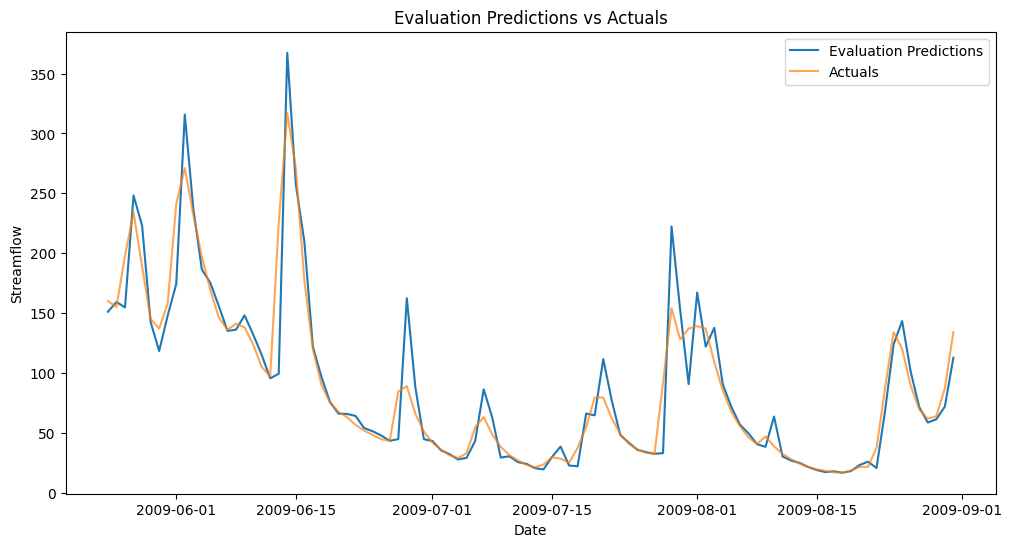

In [96]:
import matplotlib.pyplot as plt

# Plot for validation results
plt.figure(figsize=(12, 6))
plt.plot(val_results['Val Predictions'][:100], label='Evaluation Predictions')
plt.plot(val_results['Actuals'][:100], label='Actuals', alpha=0.7)
plt.title('Evaluation Predictions vs Actuals')
plt.xlabel('Date')
plt.ylabel('Streamflow')
plt.legend()
plt.show()

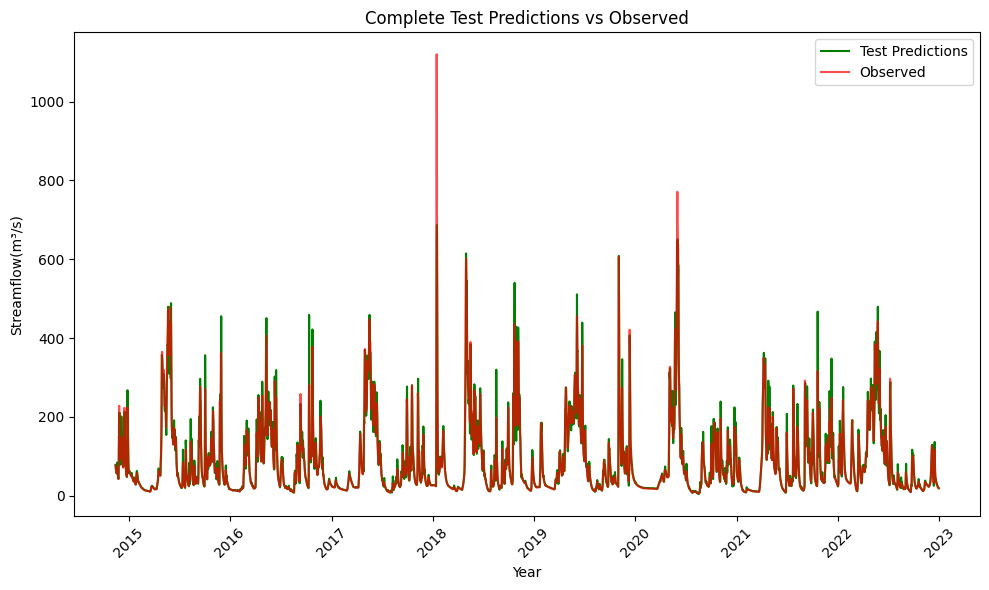

In [103]:
# Plot for complete test results
plt.figure(figsize=(10, 6))
plt.plot(test_results['Test Predictions'], label='Test Predictions', color='green')
plt.plot(test_results['Actuals'], label='Observed', color='red', alpha=0.7)
plt.title('Complete Test Predictions vs Observed')
plt.xlabel('Year')
plt.ylabel('Streamflow(m³/s)')
plt.legend()
plt.xticks(rotation=45)  # Rotate dates for better visibility if necessary
plt.tight_layout()  # Adjust layout to make room for date labels
plt.show()


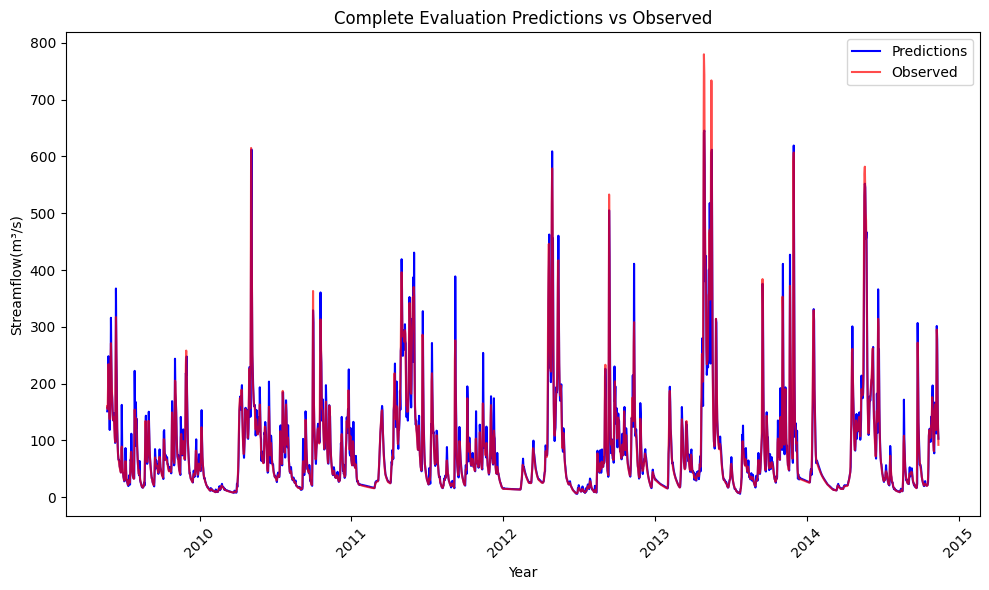

In [104]:
import matplotlib.pyplot as plt

# Plot for complete validation results
plt.figure(figsize=(10, 6))
plt.plot(val_results['Val Predictions'], label='Predictions', color='blue')
plt.plot(val_results['Actuals'], label='Observed', color='red', alpha=0.7)
plt.title('Complete Evaluation Predictions vs Observed')
plt.xlabel('Year')
plt.ylabel('Streamflow(m³/s)')
plt.legend()
plt.xticks(rotation=45)  # Rotate dates for better visibility if necessary
plt.tight_layout()  # Adjust layout to make room for date labels
plt.show()

In [106]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [107]:
def calculate_nse(actuals, predictions):
    """
    Nash-Sutcliffe Efficiency
    """
    return 1 - (np.sum((predictions - actuals) ** 2) / np.sum((actuals - np.mean(actuals)) ** 2))

def calculate_pbias(actuals, predictions):
    """
    Percent Bias
    """
    return 100.0 * (np.sum(predictions - actuals) / np.sum(actuals))

def calculate_rmse(actuals, predictions):
    """
    Root Mean Squared Error
    """
    return np.sqrt(mean_squared_error(actuals, predictions))

def calculate_mae(actuals, predictions):
    """
    Mean Absolute Error
    """
    return mean_absolute_error(actuals, predictions)

def calculate_r2(actuals, predictions):
    """
    Coefficient of Determination (R^2)
    """
    return r2_score(actuals, predictions)


In [108]:
# Assuming val_results DataFrame with columns 'Val Predictions' and 'Actuals'
actuals_val = val_results['Actuals']
predictions_val = val_results['Val Predictions']

# Calculate metrics
nse_val = calculate_nse(actuals_val, predictions_val)
pbias_val = calculate_pbias(actuals_val, predictions_val)
rmse_val = calculate_rmse(actuals_val, predictions_val)
mae_val = calculate_mae(actuals_val, predictions_val)
r2_val = calculate_r2(actuals_val, predictions_val)

# Print the results
print("Evaluation Metrics:")
print("Nash-Sutcliffe Efficiency (NSE):", nse_val)
#print("Percent Bias (PBIAS):", pbias_val)
print("Root Mean Squared Error (RMSE):", rmse_val)
print("Mean Absolute Error (MAE):", mae_val)
print("Coefficient of Determination (R^2):", r2_val)


Evaluation Metrics:
Nash-Sutcliffe Efficiency (NSE): 0.9290705315356577
Root Mean Squared Error (RMSE): 24.224117960500024
Mean Absolute Error (MAE): 10.20825672123909
Coefficient of Determination (R^2): 0.9290705315356577


In [110]:
# Print the results
print("Evaluation Metrics:")
print("Nash-Sutcliffe Efficiency (NSE): {:.2f}".format(nse_val))
#print("Percent Bias (PBIAS): {:.2f}".format(pbias_val))
print("Root Mean Squared Error (RMSE): {:.2f}".format(rmse_val))
print("Mean Absolute Error (MAE): {:.2f}".format(mae_val))
print("Coefficient of Determination (R^2): {:.2f}".format(r2_val))

Evaluation Metrics:
Nash-Sutcliffe Efficiency (NSE): 0.93
Root Mean Squared Error (RMSE): 24.22
Mean Absolute Error (MAE): 10.21
Coefficient of Determination (R^2): 0.93


In [109]:
# Assuming test_results DataFrame with columns 'Test Predictions' and 'Actuals'
actuals_test = test_results['Actuals']
predictions_test = test_results['Test Predictions']

# Calculate metrics
nse_test = calculate_nse(actuals_test, predictions_test)
pbias_test = calculate_pbias(actuals_test, predictions_test)
rmse_test = calculate_rmse(actuals_test, predictions_test)
mae_test = calculate_mae(actuals_test, predictions_test)
r2_test = calculate_r2(actuals_test, predictions_test)

# Print the results
print("Test Metrics:")
print("Nash-Sutcliffe Efficiency (NSE):", nse_test)
#print("Percent Bias (PBIAS):", pbias_test)
print("Root Mean Squared Error (RMSE):", rmse_test)
print("Mean Absolute Error (MAE):", mae_test)
print("Coefficient of Determination (R^2):", r2_test)


Test Metrics:
Nash-Sutcliffe Efficiency (NSE): 0.9348718563741074
Root Mean Squared Error (RMSE): 24.424721328761017
Mean Absolute Error (MAE): 9.683930712369154
Coefficient of Determination (R^2): 0.9348718563741074


In [111]:
# Print the results with two decimal places
print("Test Metrics:")
print("Nash-Sutcliffe Efficiency (NSE): {:.2f}".format(nse_test))
#print("Percent Bias (PBIAS): {:.2f}".format(pbias_test))
print("Root Mean Squared Error (RMSE): {:.2f}".format(rmse_test))
print("Mean Absolute Error (MAE): {:.2f}".format(mae_test))
print("Coefficient of Determination (R^2): {:.2f}".format(r2_test))


Test Metrics:
Nash-Sutcliffe Efficiency (NSE): 0.93
Root Mean Squared Error (RMSE): 24.42
Mean Absolute Error (MAE): 9.68
Coefficient of Determination (R^2): 0.93


In [ ]:
# Predictions for validation set
val_predictions = model1.predict(X_val1).flatten()
val_results = pd.DataFrame({'Val Predictions': val_predictions, 'Actuals': y_val1})

# Predictions for test set
test_predictions = model1.predict(X_test1).flatten()
test_results = pd.DataFrame({'Test Predictions': test_predictions, 'Actuals': y_test1})



93/93 [==============================] - 0s 3ms/step


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Function to plot correlation
def plot_correlation(data, x, y, title):
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=x, y=y, data=data)
    plt.title(title)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    # Adding a line of best fit
    sns.regplot(x=x, y=y, data=data, scatter=False)
    plt.show()

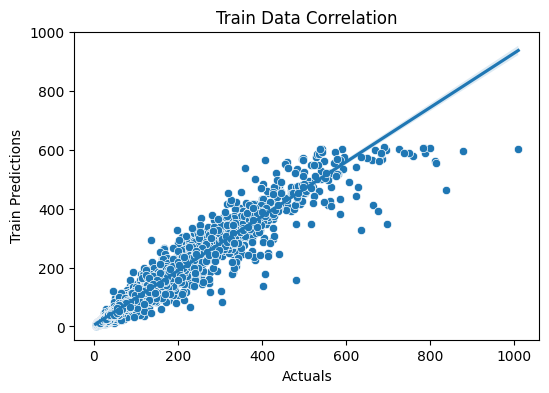

In [ ]:
# Plot correlations for Train, Validation, and Test sets
plot_correlation(train_results, 'Actuals', 'Train Predictions', 'Train Data Correlation')


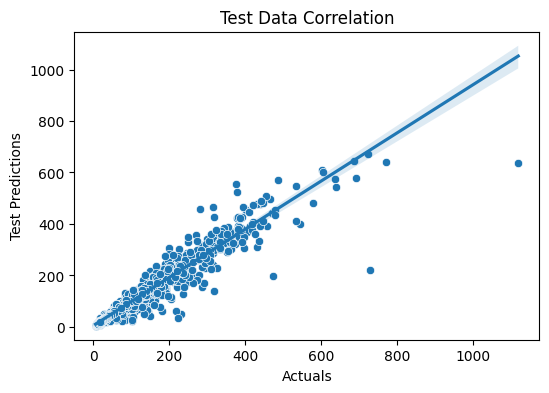

In [ ]:
plot_correlation(test_results, 'Actuals', 'Test Predictions', 'Test Data Correlation')

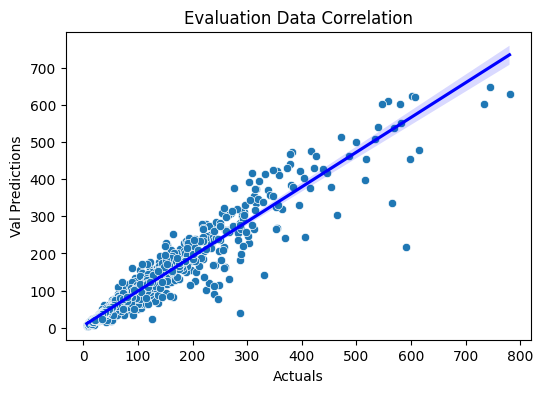

In [ ]:
plot_correlation(val_results, 'Actuals', 'Val Predictions', 'Evaluation Data Correlation')

In [ ]:
val_predictions = model1.predict(X_val1).flatten()
test_predictions = model1.predict(X_test1).flatten()

val_results = pd.DataFrame({'Val Predictions': val_predictions, 'Actuals': y_val1})
test_results = pd.DataFrame({'Test Predictions': test_predictions, 'Actuals': y_test1})


93/93 [==============================] - 1s 6ms/step


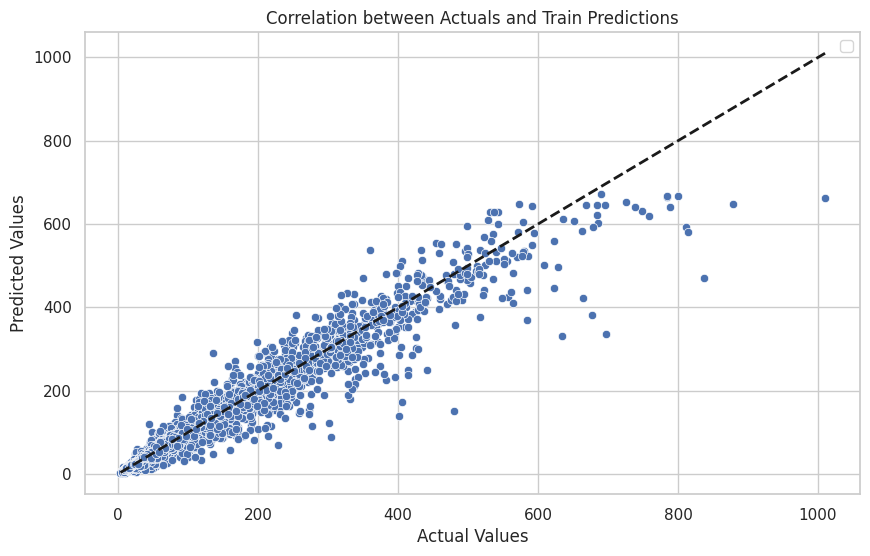

In [ ]:
# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Training data plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=train_results['Actuals'], y=train_results['Train Predictions'])
plt.plot([train_results['Actuals'].min(), train_results['Actuals'].max()], [train_results['Actuals'].min(), train_results['Actuals'].max()], 'k--', lw=2)  # Diagonal line for reference
plt.title('Correlation between Actuals and Train Predictions')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()


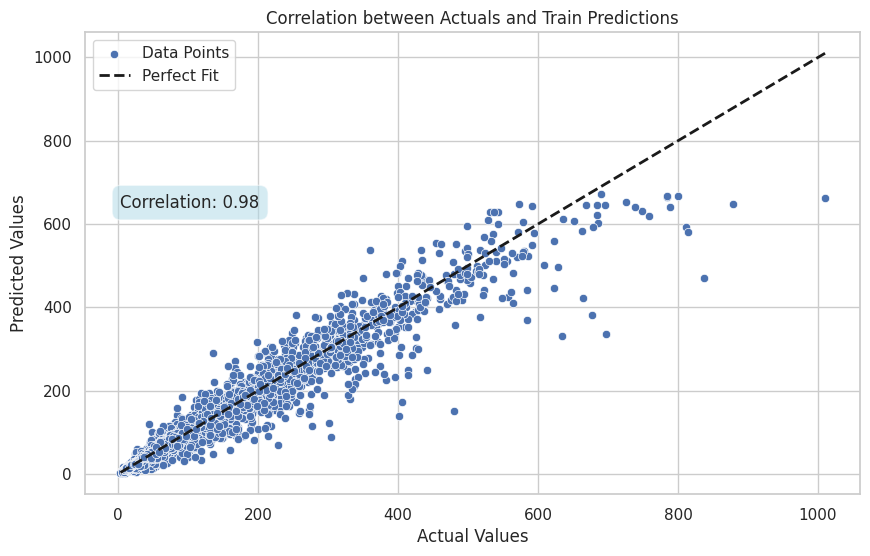

In [ ]:
plt.figure(figsize=(10, 6))

# Plotting the scatter plot
sns.scatterplot(x=train_results['Actuals'], y=train_results['Train Predictions'], label='Data Points')

# Adding a diagonal reference line
plt.plot([train_results['Actuals'].min(), train_results['Actuals'].max()],
         [train_results['Actuals'].min(), train_results['Actuals'].max()],
         'k--', lw=2, label='Perfect Fit')

# Title and labels
plt.title('Correlation between Actuals and Train Predictions')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

# Calculate and display the correlation coefficient
corr_coef = np.corrcoef(train_results['Actuals'], train_results['Train Predictions'])[0, 1]
plt.text(x=min(train_results['Actuals']), y=max(train_results['Train Predictions']),
         s=f'Correlation: {corr_coef:.2f}',
         fontsize=12,
         verticalalignment='top',
         bbox=dict(boxstyle='round,pad=0.5', facecolor='lightblue', alpha=0.5))

# Show legend
plt.legend()

# Display the plot
plt.show()


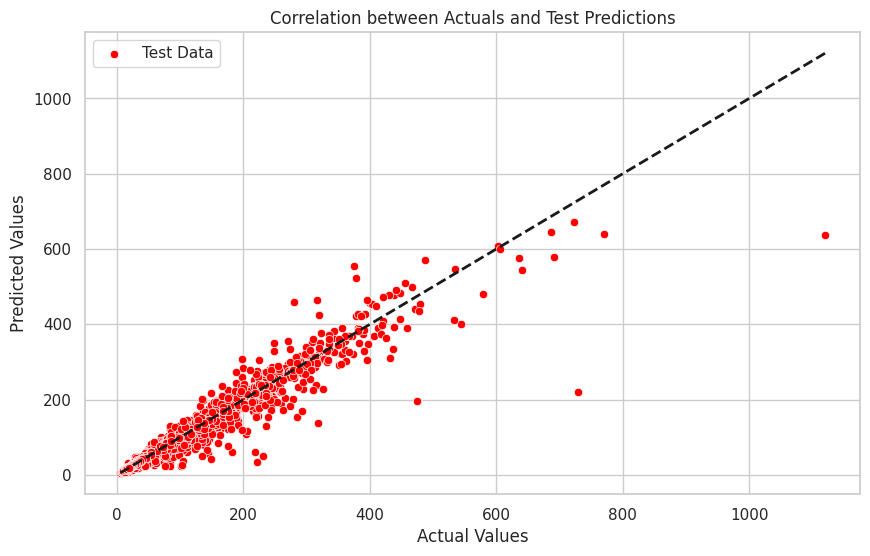

In [ ]:
# Test data plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=test_results['Actuals'], y=test_results['Test Predictions'], color='red', label='Test Data')
plt.plot([test_results['Actuals'].min(), test_results['Actuals'].max()], [test_results['Actuals'].min(), test_results['Actuals'].max()], 'k--', lw=2)  # Diagonal line for reference
plt.title('Correlation between Actuals and Test Predictions')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()

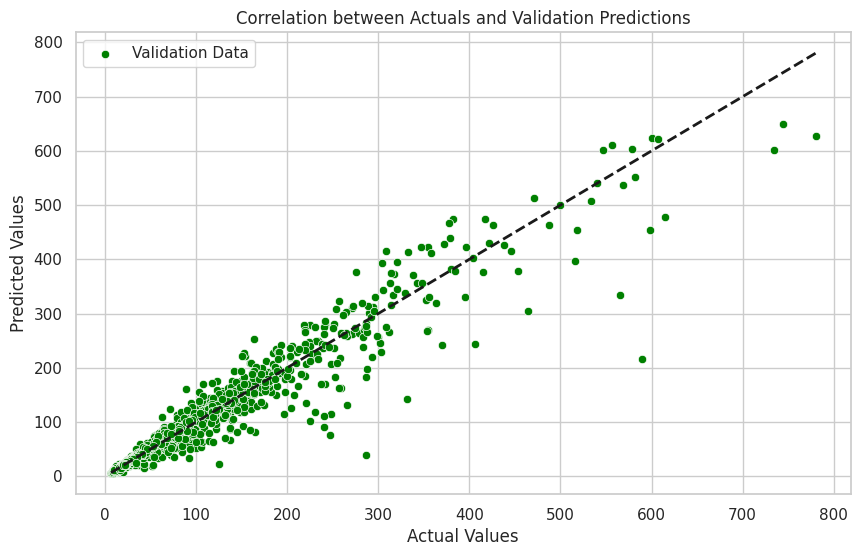

In [ ]:
# Validation data plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=val_results['Actuals'], y=val_results['Val Predictions'], color='green', label='Validation Data')
plt.plot([val_results['Actuals'].min(), val_results['Actuals'].max()], [val_results['Actuals'].min(), val_results['Actuals'].max()], 'k--', lw=2)  # Diagonal line for reference
plt.title('Correlation between Actuals and Validation Predictions')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()

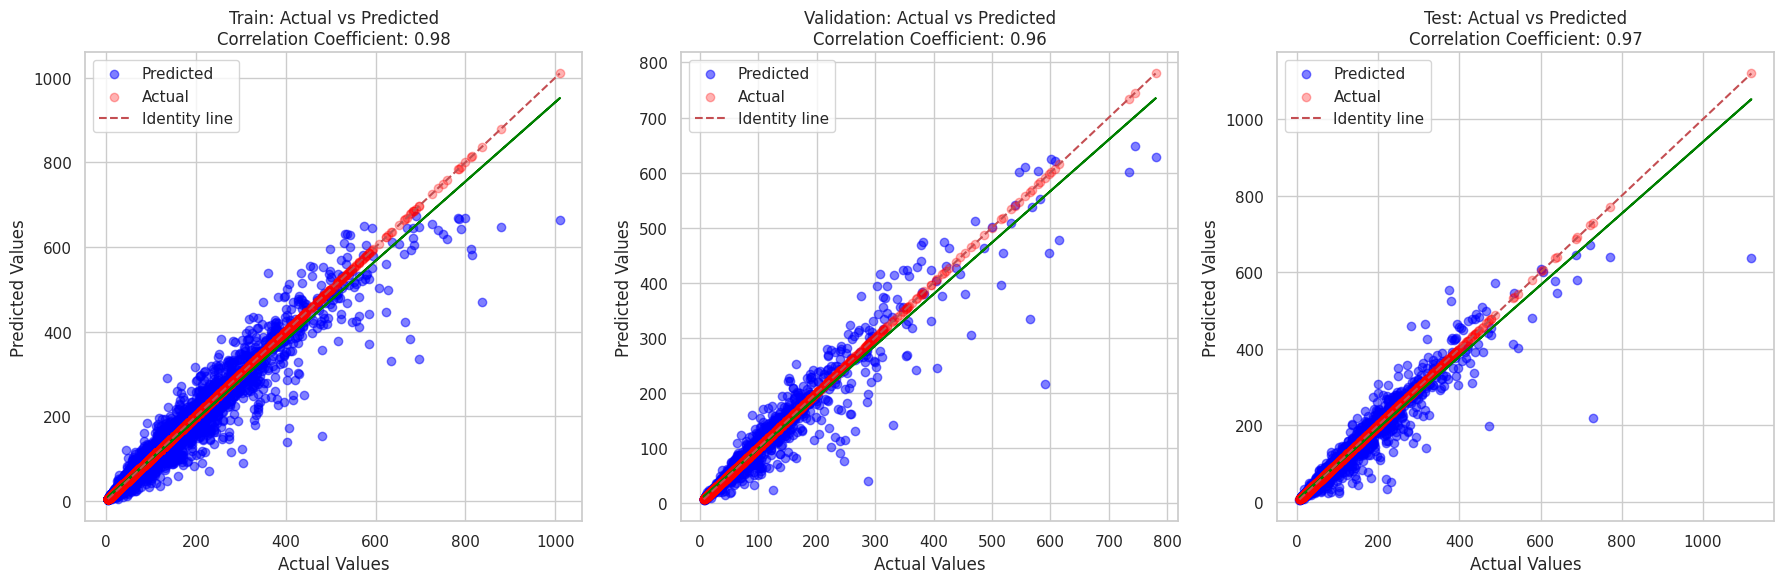

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Set up the matplotlib figure
plt.figure(figsize=(18, 6))

# Define a function to plot correlation
def plot_correlation(ax, actuals, predictions, title):
    # Scatter plot
    ax.scatter(actuals, predictions, color='blue', alpha=0.5, label='Predicted')
    ax.scatter(actuals, actuals, color='red', alpha=0.3, label='Actual')

    # Fit line (best fit for predicted)
    m, b = np.polyfit(actuals, predictions, 1)
    ax.plot(actuals, m*actuals + b, color='green')

    # Correlation coefficient
    corr_coef = np.corrcoef(actuals, predictions)[0, 1]

    # Plotting the identity line
    ax.plot([actuals.min(), actuals.max()], [actuals.min(), actuals.max()], 'r--', label='Identity line')

    # Set titles and labels
    ax.set_title(f'{title}\nCorrelation Coefficient: {corr_coef:.2f}')
    ax.set_xlabel('Actual Values')
    ax.set_ylabel('Predicted Values')

    # Add legend
    ax.legend()

# Training Data Plot
ax1 = plt.subplot(1, 3, 1)
plot_correlation(ax1, train_results['Actuals'], train_results['Train Predictions'], 'Train: Actual vs Predicted')

# Validation Data Plot
ax2 = plt.subplot(1, 3, 2)
plot_correlation(ax2, val_results['Actuals'], val_results['Val Predictions'], 'Validation: Actual vs Predicted')

# Test Data Plot
ax3 = plt.subplot(1, 3, 3)
plot_correlation(ax3, test_results['Actuals'], test_results['Test Predictions'], 'Test: Actual vs Predicted')

# Display the plot
plt.tight_layout()
plt.show()


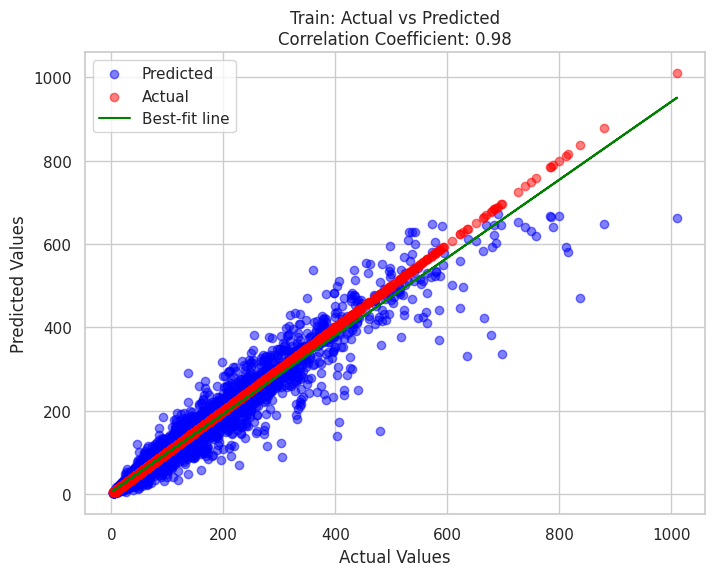

In [ ]:

import matplotlib.pyplot as plt
import numpy as np

def plot_correlation(ax, actuals, predictions, title):
    # Scatter plot for predictions
    ax.scatter(actuals, predictions, color='blue', alpha=0.5, label='Predicted')
    # Scatter plot for actuals (overlaid for comparison)
    ax.scatter(actuals, actuals, color='red', alpha=0.5, label='Actual')

    # Fit line (best fit for predictions)
    m, b = np.polyfit(actuals, predictions, 1)
    ax.plot(actuals, m*actuals + b, color='green', label='Best-fit line')

    # Correlation coefficient
    corr_coef = np.corrcoef(actuals, predictions)[0, 1]

    # Identity line (shows perfect prediction)
    #ax.plot([actuals.min(), actuals.max()], [actuals.min(), actuals.max()], 'r--', label='Identity line')

    # Setting titles and labels
    ax.set_title(f'{title}\nCorrelation Coefficient: {corr_coef:.2f}')
    ax.set_xlabel('Actual Values')
    ax.set_ylabel('Predicted Values')

    # Add legend to the plot
    ax.legend()
# Set up the matplotlib figure
fig, ax1 = plt.subplots(figsize=(8, 6))

# Training Data Plot
plot_correlation(ax1, train_results['Actuals'], train_results['Train Predictions'], 'Train: Actual vs Predicted')

# Display the plot
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns  # Importing seaborn for enhanced visualization

# Combining results from train, validation, and test datasets
# Each dataset's predictions are renamed to a common column name for uniformity
combined_results = pd.concat([
    train_results.rename(columns={'Train Predictions': 'Predictions'})[['Predictions', 'Actuals']],
    val_results.rename(columns={'Val Predictions': 'Predictions'})[['Predictions', 'Actuals']],
    test_results.rename(columns={'Test Predictions': 'Predictions'})[['Predictions', 'Actuals']]
], ignore_index=True)  # Ensure a new index is set for the combined DataFrame

# Reshape the DataFrame for suitable plotting using 'melt'
# This changes the DataFrame format from wide to long
melted_results = pd.melt(combined_results, id_vars='Date', value_vars=['Predictions', 'Actuals'])

# Plotting the data using seaborn's boxplot for better style and visualization
plt.figure(figsize=(12, 6))
sns.boxplot(x='variable', y='value', data=melted_results)
plt.title('Comparison of Predictions and Actuals Across Different Sets')
plt.xlabel('Category')
plt.ylabel('Streamflow')
plt.show()


KeyError: 'Date'